# Search-based Fuzzing

Sometimes we are not only interested in fuzzing as many as possible diverse program inputs, but in deriving *specific* test inputs that achieve some objective, such as reaching specific statements in a program. When we have an idea of what we are looking for, then we can *search* for it. Search algorithms are at the core of computer science, but applying classic search algorithms like breadth or depth first search to search for tests is unrealistic, because these algorithms potentially require us to look at all possible inputs. However, domain-knowledge can be used to overcome this problem. For example, if we can estimate which of several program inputs is closer to the one we are looking for, then this information can guide us to reach the target quicker -- this information is known as a *heuristic*. The way heuristics are applied systematically is captured in *meta-heuristic* search algorithms. The "meta" denotes that these algorithm are generic and can be instantiated differently to different problems. Meta-heuristics often take inspiration from processes observed in nature. For example, there are algorithms mimicking evolutionary processes, swarm intelligence, or chemical reactions. In general they are much more efficient than exhaustive search approaches such that they can be applied to vast search spaces --- search spaces as vast as the domain of program inputs are no problem for them.

**Prerequisites**

* You should know how code coverage works, e.g. from the [chapter on coverage](Coverage.ipynb).

## Test Generation as a Search Problem

If we want to apply a meta-heuristic search algorithm to generate test data for a program, then we have to make several choices: First, we need to decide on what exactly our *search space* is in the first place. The search space is defined by how we *represent* what we are looking for. Are we looking for single integer values? Tuples of values? Objects? XML documents? 

### Representing program inputs as a search problem

The representation is highly dependent on the particular testing problem we are solving --- we know which program we are testing, so the representation needs to encode whatever an input to our target program is. Let's consider the example function `testMe` as our function under test: 

In [32]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True 
    else:
        return False

The `test_me` function has two input parameters, and returns `True` or `False` depending on how the two relate to each other. A test input to `test_me` consists of a pair of values, one for `x` and one for `y`. For example:

In [33]:
print(test_me(0, 0))
print(test_me(4, 2))
print(test_me(22, 10))

False
False
True


Our search space is only concerned with inputs, thus a simple representation for test data would be input tuples `(x, y)`. Each point in this input space has eight *neighbours*:

- `x-1, y-1`
- `x-1, y`
- `x-1, y+1`
- `x, y+1`
- `x+1, y+1`
- `x+1, y`
- `x, y-1`

To keep things simple, let's restrict the size of our search space to start with (we will change this later). For example, let's assume we only want values in the range of -10000 to 10000:

In [13]:
MIN=-10000
MAX=10000

To retrieve the neighbours for any point in our search space, we define the function `neighbours`:

In [15]:
def neighbours(x, y):
    return [(x+dx, y+dy) for dx in [-1,0,1] \
                         for dy in [-1,0,1] \
                         if (dx != 0 or dy != 0)\
                            and ((MIN <= x+dx <= MAX) \
                            and (MIN <= y+dy <= MAX))]

In [16]:
print(neighbours(10, 10))

[(9, 9), (9, 10), (9, 11), (10, 9), (10, 11), (11, 9), (11, 10), (11, 11)]


This fully defines our search space: We have a representation, and we know how individuals are related to each other through their neighbourhood. Now we just need to find an algorithm to explore this neighbourhood.

### Defining a search landscape: Fitness functions

All meta-heuristics are based on the use of a heuristic function that estimates how good a given candidate solution is; this "goodness" is typically called the *fitness* of an individual, and the heuristic that estimates the fitness is the *fitness function*. The fitness function is a function that maps any point in the search space to a numerical value, the fitness value. If you plot each point in the search space with its fitness value as the height, you get a landscape with the optimal solution represented as the highest peak.

The fitness function depends on the objective one would like to achieve with generating the test data. Suppose that we are interested in covering the true branch of the if-condition in the `test_me` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [17]:
x = 274
y = 153
print(x)
print(2 * (y + 1))

274
308


In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [34]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

print(calculate_distance(274, 153))

34


For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

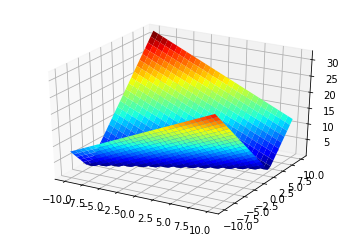

In [35]:
from mpl_toolkits.mplot3d import Axes3D

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)


The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

### Instrumentation

The fitness function should calculate the distance value for concrete test executions. That is, we want to run the program, and then learn the distance value of this execution. However, the branching condition is hidden within the source code of the target function, and its value may in principle be the result of various calculations along the execution path reaching it. Even though in our example the condition is an equation using the input values of the function directly, this may not be the case in general; it might as well be derived values. Thus, the values we need to calculate our distance metric need to be observed directly at the conditional statement.

This is typically done with *instrumentation*: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values. The following is an instrumented version of our program under test, which prints out the distance values as it is executed:

In [45]:
def test_me_instrumented(x, y):
    
    print("Instrumentation: Input = (%d, %d), distance = %d" % (x, y, calculate_distance(x,y)))
    if x == 2*(y+1):
        return True 
    else:
        return False

Let's try this out for a couple of example values:

In [48]:
test_me_instrumented(0, 0)
test_me_instrumented(5, 2)
test_me_instrumented(22, 10)

Instrumentation: Input = (0, 0), distance = 2
Instrumentation: Input = (5, 2), distance = 1
Instrumentation: Input = (22, 10), distance = 0


True

When calculating a fitness value, we will execute the instrumented program version, but we need some means to access the distance value calculated during that execution. As a simple first solution to this problem, we can simply add a global variable and store the value of the distance calculation there. 

In [64]:
distance = 0
def test_me_instrumented(x, y):
    global distance
    distance = calculate_distance(x, y)
    if x == 2*(y+1):
        return True 
    else:
        return False

Using this instrumented version of `test_me`, we can now finally define our fitness function, which simply runs the instrumented `test_me_instrumented` function, and then retrieves the value of the global `distance` variable:

In [65]:
def get_fitness(x, y):
    global distance
    test_me_instrumented(x, y)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [67]:
print("Fitness of (0, 0)  = %d" % get_fitness(0, 0))
print("Fitness of (1, 2)  = %d" % get_fitness(1, 2))
print("Fitness of (22,10) = %d" % get_fitness(22,10))

Fitness of (0, 0)  = 2
Fitness of (1, 2)  = 5
Fitness of (22,10) = 0


### Hillclimbing the example

Having decided on a representation (2-tuples of integers) and a fitness function (distance to target branch), we can now finally go ahead and implement our search algorithm. Let's explore this search space using the simplest possible meta-heuristic algorithm: Hillclimbing. The metaphor captures aptly what is happening: The algorithm tries to climb a hill in the search space defined by our representation. Except, that in our search landscape the best values are not those high up but down low, so technically we are are descending into valleys.

The hillclimbing algorithm itself is very simple: 
1. Take a random starting point
2. Determine fitness value of all neighbours
3. Move to neighbour with the best fitness value
4. If solution is not found, continue with step 2

The hillclimber starts with a random test input, i.e., random values for `x` and `y`. For any pair of random integer numbers, the chances of them satisfying the condition `x == 2 * (y + 1)` are rather slim. Suppose the random values are `(274, 153)`. The right hand side of the equation, `2 * (y + 1)`, evaluates to 308, so the condition is clearly false. Where should the hillclimber go to now? Let's look at the fitness values of this test input and its neighbours:

In [77]:
x, y = 274, 153
print("%d, %d: %d" % (x, y, get_fitness(x, y)))
for nx, ny in neighbours(x, y):
    print("%d, %d: %d" % (nx, ny, get_fitness(nx, ny)))

274, 153: 34
273, 152: 33
273, 153: 35
273, 154: 37
274, 152: 32
274, 154: 36
275, 152: 31
275, 153: 33
275, 154: 35


Increasing `y` by one increases the value of the right hand side of the equation to `310`. Thus, the value on the left hand side of the equation thus differs *even more* to the value on the right hand side of the equation than it did before the increase! So, increasing `y` does not seem like a good idea. On the other hand, increasing `x` by one improves things: The left hand side and the right hand side of the equation become more similar; they are "less unequal". Thus, out of the eight possible neighbors of `(274, 153)`, the neighbor that increases `x` and decreases `y` (`(275, 152)`) seems best intuitively --- the outcome of the condition is still false, but it is "less so" than for the original value.

Let's now implement the hillcimbing algorithm. 

In [78]:
import random

# Create and evaluate starting point
x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
fitness = get_fitness(x, y)
print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))

# Stop once we have found an optimal solution
while fitness > 0:
    # Move to first neighbour with a better fitness 
    for (nextx, nexty) in neighbours(x,y):
        new_fitness = get_fitness(nextx, nexty)
        if new_fitness < fitness:
            x, y = nextx, nexty
            fitness = new_fitness
            changed = True
            print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
            break

print("Optimum at %d, %d" % (x, y))

Initial value: 984, -4784 at fitness 10550.0000
New value: 983, -4784 at fitness 10549.0000
New value: 982, -4784 at fitness 10548.0000
New value: 981, -4784 at fitness 10547.0000
New value: 980, -4784 at fitness 10546.0000
New value: 979, -4784 at fitness 10545.0000
New value: 978, -4784 at fitness 10544.0000
New value: 977, -4784 at fitness 10543.0000
New value: 976, -4784 at fitness 10542.0000
New value: 975, -4784 at fitness 10541.0000
New value: 974, -4784 at fitness 10540.0000
New value: 973, -4784 at fitness 10539.0000
New value: 972, -4784 at fitness 10538.0000
New value: 971, -4784 at fitness 10537.0000
New value: 970, -4784 at fitness 10536.0000
New value: 969, -4784 at fitness 10535.0000
New value: 968, -4784 at fitness 10534.0000
New value: 967, -4784 at fitness 10533.0000
New value: 966, -4784 at fitness 10532.0000
New value: 965, -4784 at fitness 10531.0000
New value: 964, -4784 at fitness 10530.0000
New value: 963, -4784 at fitness 10529.0000
New value: 962, -4784 at fit

New value: -183, -4784 at fitness 9383.0000
New value: -184, -4784 at fitness 9382.0000
New value: -185, -4784 at fitness 9381.0000
New value: -186, -4784 at fitness 9380.0000
New value: -187, -4784 at fitness 9379.0000
New value: -188, -4784 at fitness 9378.0000
New value: -189, -4784 at fitness 9377.0000
New value: -190, -4784 at fitness 9376.0000
New value: -191, -4784 at fitness 9375.0000
New value: -192, -4784 at fitness 9374.0000
New value: -193, -4784 at fitness 9373.0000
New value: -194, -4784 at fitness 9372.0000
New value: -195, -4784 at fitness 9371.0000
New value: -196, -4784 at fitness 9370.0000
New value: -197, -4784 at fitness 9369.0000
New value: -198, -4784 at fitness 9368.0000
New value: -199, -4784 at fitness 9367.0000
New value: -200, -4784 at fitness 9366.0000
New value: -201, -4784 at fitness 9365.0000
New value: -202, -4784 at fitness 9364.0000
New value: -203, -4784 at fitness 9363.0000
New value: -204, -4784 at fitness 9362.0000
New value: -205, -4784 at fitnes

New value: -1254, -4784 at fitness 8312.0000
New value: -1255, -4784 at fitness 8311.0000
New value: -1256, -4784 at fitness 8310.0000
New value: -1257, -4784 at fitness 8309.0000
New value: -1258, -4784 at fitness 8308.0000
New value: -1259, -4784 at fitness 8307.0000
New value: -1260, -4784 at fitness 8306.0000
New value: -1261, -4784 at fitness 8305.0000
New value: -1262, -4784 at fitness 8304.0000
New value: -1263, -4784 at fitness 8303.0000
New value: -1264, -4784 at fitness 8302.0000
New value: -1265, -4784 at fitness 8301.0000
New value: -1266, -4784 at fitness 8300.0000
New value: -1267, -4784 at fitness 8299.0000
New value: -1268, -4784 at fitness 8298.0000
New value: -1269, -4784 at fitness 8297.0000
New value: -1270, -4784 at fitness 8296.0000
New value: -1271, -4784 at fitness 8295.0000
New value: -1272, -4784 at fitness 8294.0000
New value: -1273, -4784 at fitness 8293.0000
New value: -1274, -4784 at fitness 8292.0000
New value: -1275, -4784 at fitness 8291.0000
New value:

New value: -2423, -4784 at fitness 7143.0000
New value: -2424, -4784 at fitness 7142.0000
New value: -2425, -4784 at fitness 7141.0000
New value: -2426, -4784 at fitness 7140.0000
New value: -2427, -4784 at fitness 7139.0000
New value: -2428, -4784 at fitness 7138.0000
New value: -2429, -4784 at fitness 7137.0000
New value: -2430, -4784 at fitness 7136.0000
New value: -2431, -4784 at fitness 7135.0000
New value: -2432, -4784 at fitness 7134.0000
New value: -2433, -4784 at fitness 7133.0000
New value: -2434, -4784 at fitness 7132.0000
New value: -2435, -4784 at fitness 7131.0000
New value: -2436, -4784 at fitness 7130.0000
New value: -2437, -4784 at fitness 7129.0000
New value: -2438, -4784 at fitness 7128.0000
New value: -2439, -4784 at fitness 7127.0000
New value: -2440, -4784 at fitness 7126.0000
New value: -2441, -4784 at fitness 7125.0000
New value: -2442, -4784 at fitness 7124.0000
New value: -2443, -4784 at fitness 7123.0000
New value: -2444, -4784 at fitness 7122.0000
New value:

New value: -3682, -4784 at fitness 5884.0000
New value: -3683, -4784 at fitness 5883.0000
New value: -3684, -4784 at fitness 5882.0000
New value: -3685, -4784 at fitness 5881.0000
New value: -3686, -4784 at fitness 5880.0000
New value: -3687, -4784 at fitness 5879.0000
New value: -3688, -4784 at fitness 5878.0000
New value: -3689, -4784 at fitness 5877.0000
New value: -3690, -4784 at fitness 5876.0000
New value: -3691, -4784 at fitness 5875.0000
New value: -3692, -4784 at fitness 5874.0000
New value: -3693, -4784 at fitness 5873.0000
New value: -3694, -4784 at fitness 5872.0000
New value: -3695, -4784 at fitness 5871.0000
New value: -3696, -4784 at fitness 5870.0000
New value: -3697, -4784 at fitness 5869.0000
New value: -3698, -4784 at fitness 5868.0000
New value: -3699, -4784 at fitness 5867.0000
New value: -3700, -4784 at fitness 5866.0000
New value: -3701, -4784 at fitness 5865.0000
New value: -3702, -4784 at fitness 5864.0000
New value: -3703, -4784 at fitness 5863.0000
New value:

New value: -5085, -4784 at fitness 4481.0000
New value: -5086, -4784 at fitness 4480.0000
New value: -5087, -4784 at fitness 4479.0000
New value: -5088, -4784 at fitness 4478.0000
New value: -5089, -4784 at fitness 4477.0000
New value: -5090, -4784 at fitness 4476.0000
New value: -5091, -4784 at fitness 4475.0000
New value: -5092, -4784 at fitness 4474.0000
New value: -5093, -4784 at fitness 4473.0000
New value: -5094, -4784 at fitness 4472.0000
New value: -5095, -4784 at fitness 4471.0000
New value: -5096, -4784 at fitness 4470.0000
New value: -5097, -4784 at fitness 4469.0000
New value: -5098, -4784 at fitness 4468.0000
New value: -5099, -4784 at fitness 4467.0000
New value: -5100, -4784 at fitness 4466.0000
New value: -5101, -4784 at fitness 4465.0000
New value: -5102, -4784 at fitness 4464.0000
New value: -5103, -4784 at fitness 4463.0000
New value: -5104, -4784 at fitness 4462.0000
New value: -5105, -4784 at fitness 4461.0000
New value: -5106, -4784 at fitness 4460.0000
New value:

New value: -6181, -4784 at fitness 3385.0000
New value: -6182, -4784 at fitness 3384.0000
New value: -6183, -4784 at fitness 3383.0000
New value: -6184, -4784 at fitness 3382.0000
New value: -6185, -4784 at fitness 3381.0000
New value: -6186, -4784 at fitness 3380.0000
New value: -6187, -4784 at fitness 3379.0000
New value: -6188, -4784 at fitness 3378.0000
New value: -6189, -4784 at fitness 3377.0000
New value: -6190, -4784 at fitness 3376.0000
New value: -6191, -4784 at fitness 3375.0000
New value: -6192, -4784 at fitness 3374.0000
New value: -6193, -4784 at fitness 3373.0000
New value: -6194, -4784 at fitness 3372.0000
New value: -6195, -4784 at fitness 3371.0000
New value: -6196, -4784 at fitness 3370.0000
New value: -6197, -4784 at fitness 3369.0000
New value: -6198, -4784 at fitness 3368.0000
New value: -6199, -4784 at fitness 3367.0000
New value: -6200, -4784 at fitness 3366.0000
New value: -6201, -4784 at fitness 3365.0000
New value: -6202, -4784 at fitness 3364.0000
New value:

New value: -7680, -4784 at fitness 1886.0000
New value: -7681, -4784 at fitness 1885.0000
New value: -7682, -4784 at fitness 1884.0000
New value: -7683, -4784 at fitness 1883.0000
New value: -7684, -4784 at fitness 1882.0000
New value: -7685, -4784 at fitness 1881.0000
New value: -7686, -4784 at fitness 1880.0000
New value: -7687, -4784 at fitness 1879.0000
New value: -7688, -4784 at fitness 1878.0000
New value: -7689, -4784 at fitness 1877.0000
New value: -7690, -4784 at fitness 1876.0000
New value: -7691, -4784 at fitness 1875.0000
New value: -7692, -4784 at fitness 1874.0000
New value: -7693, -4784 at fitness 1873.0000
New value: -7694, -4784 at fitness 1872.0000
New value: -7695, -4784 at fitness 1871.0000
New value: -7696, -4784 at fitness 1870.0000
New value: -7697, -4784 at fitness 1869.0000
New value: -7698, -4784 at fitness 1868.0000
New value: -7699, -4784 at fitness 1867.0000
New value: -7700, -4784 at fitness 1866.0000
New value: -7701, -4784 at fitness 1865.0000
New value:

New value: -9148, -4784 at fitness 418.0000
New value: -9149, -4784 at fitness 417.0000
New value: -9150, -4784 at fitness 416.0000
New value: -9151, -4784 at fitness 415.0000
New value: -9152, -4784 at fitness 414.0000
New value: -9153, -4784 at fitness 413.0000
New value: -9154, -4784 at fitness 412.0000
New value: -9155, -4784 at fitness 411.0000
New value: -9156, -4784 at fitness 410.0000
New value: -9157, -4784 at fitness 409.0000
New value: -9158, -4784 at fitness 408.0000
New value: -9159, -4784 at fitness 407.0000
New value: -9160, -4784 at fitness 406.0000
New value: -9161, -4784 at fitness 405.0000
New value: -9162, -4784 at fitness 404.0000
New value: -9163, -4784 at fitness 403.0000
New value: -9164, -4784 at fitness 402.0000
New value: -9165, -4784 at fitness 401.0000
New value: -9166, -4784 at fitness 400.0000
New value: -9167, -4784 at fitness 399.0000
New value: -9168, -4784 at fitness 398.0000
New value: -9169, -4784 at fitness 397.0000
New value: -9170, -4784 at fitne

The hillclimber starts by choosing random values for `x` and `y`. We use low values in the range of `0`--`1000` to reduce the time search takes when playing with the example. Then, we determine the fitness value of this starting point by calling `get_fitness`. Recall that we are trying to find the smallest possible fitness value, therefore we now loop until we have either found a fitness value of `0` (i.e., an optimal value) or until we have reached a local optimum (i.e., all neighbours have same or worse fitness). 

In this loop, we iterate over all neighbours (`neighbours`), and evaluate the fitness value of each of the neighbours. As soon as we have found a neighbour with better (smaller) fitness, the hillclimber exits the loop and uses this as the new starting point. An alternative variant of this simple hillclimbing algorithm would be to remove the `break` statement: By doing so, *all* neighbours would be evaluated and the best neighbour would be chosen --- this is known as *steepest ascent hillclimbing*.

Our example program has a very nice fitness landscape --- there is a perfect gradient, and the hillclimber will always find a solution. Things become more tricky if that is not the case. The hillclimber only works well as long as there is at least one neighbour that has a better fitness value. If one has reached a local optimum, then no neighbour has a better fitness. If one is stuck on a plateau, then all neighbours have the same fitness value. In these cases, the only way out is a random restart. 


In [ ]:
import random

# Create and evaluate starting point
x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
fitness = get_fitness(x, y)
print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))

# Stop once we have found an optimal solution
while fitness > 0:
    changed = False
    # Move to first neighbour with a better fitness 
    for (nextx, nexty) in neighbours(x,y):
        new_fitness = get_fitness(nextx, nexty)
        if new_fitness < fitness:
            x, y = nextx, nexty
            fitness = new_fitness
            changed = True
            print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
            break

    if not changed:
        x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
        fitness = get_fitness(x, y)

print("Optimum at %d, %d" % (x, y))

TODO: Change test_me function such that restarts are necessary.

Exercises:
- Different function under test
- Random restarts
- Steepest descent

## Testing a More Complex Program

The hillclimber found the solution to the `testMe` example quickly. However, there are several points to note about this example: First, there is just only one local optimum. Second, we restricted initial values of `x` and `y` to the range `[0, 1000]`. The latter is a common trick in test generation, as in *most* cases solutions tend to consist of small values, and using small values to start the search makes the search quicker in many cases. However, what if the solution we need is at a completely different place in our search space? Our bias towards smaller solutions would mean that the hillclimber would take very long to find the solution, and given a fixed search budget it would thus be less likely to actually find a solution. To see what effects this would have, simply try replacing the `1000` with `sys.maxint` in the example and run the hillclimber again: You will note that in most cases the search now will take extremely long until a solution is found --- much longer than we are prepared to wait for such a simple example function! How is this ever going to work on "real" examples? Not to imagine if there were even more parameters!

In [ ]:
MAX=sys.maxint
MIN=-sys.maxint
# TODO: Call hillclimber again

### CGI Decoder as a Search Problem

Let's turn to a slightly more complex program: The CGI decoder you already know from chapter TODO. This function has one input of type string, and one possible way to define the neighbourhood of a string is by all possible strings that have an edit distance of 1. For example, string `test` would have two neighbours for each character:

- `uest`
- `tfst`
- `tett`
- `tesu`
- `sest`
- `tdst`
- `tert`
- `tess`

In addition, prepending any character or appending any character would also have an edit distance of 1 and could be considered neighbours. To keep things simple, let's keep the length of our input strings fixed to a reasonable value (e.g. 10). In this case, each individual has 20 neighbours.

TODO: explain neighbours function

In [ ]:
def neighbours(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      if c < 256:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 0:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]

### Branch Distances

Deriving a fitness function for the `testMe` function was easy, but the way we added a global variable and method call to the program seems like a rather clumsy approach --- surely we cannot start thinking about every branch in our program on its own and instrument the program we want to test manually, in particular if programs have multiple branches like the `cgi_decode` function. Rather, we should be looking at how to automatically instrument programs to contain the necessary added statements such that we can calculate fitness values.

The fitness calculation we used in the simple example was based on estimating the distance to making a branch evaluate to a desired outcome; this is generally referred to as its *branch distance*. Branching conditions may be more complex than the simple equality check in our example. However, the concept of branch distance can be very easily extended to other types of equations.

The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


For each type of comparison, there are two possible distances: The distance to making the comparison true, and the distance to making the comparison false. In general, the branch distance is defined as `0` if the branch already evaluates to the target outcome. That is, if `a` is smaller than `b`, then the true-distance of `a < b` is `0` by definition. Similarly, if `a` differs from `b` then the false-distance of `a == b` is `0`. Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

TODO: `digit_high in hex_values`


### Dealing with Complex Conditions

In the `cgi_decode` function, we can also find a somewhat more complex predicate which consists of several comparisons:

`
if digit_high in hex_values and digit_low in hex_values:
`

In principle, the branch distance is defined such that the distance to make a conjunction `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the minimum of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true. 

However, it is not as easy as that in practice: Predicates can consist of nested conditions and negations, and one would need to convert the expression to canonical form before being able to apply this calculation. Furthermore, most modern programming languages use *short-circuit evaluation*: If there is a condition `A or B`, and `A` is true, then `B` is never evaluated. If `B` is an expression with side-effects, then by calculating the branch distance of `B` even though short-circuit evaluation would avoid its execution, we would potentially be changing the program behavior (by invoking the side-effect that would in normal behavior not be executed), and that is not acceptable.


Furthermore, what if the branching condition has side-effects? For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo` being executed *twice*. Suppose `foo` changes the state of the system (e.g., by printing something, accessing the filesystem, changing some state variables, etc.), then clearly invoking `foo` a second time is a bad idea. One way to overcome this problem is to transform the conditions, rather than adding tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = abs(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

The same effect can be achieved without temporary variables by replacing the actual comparison with a call to a helper function, where the original expressions are evaluated as arguments, and the operator is an additional argument. Assume a `BranchPredicate` function which takes four parameters: `num` is a unique id that identifies the branching predicate; `op` is the operator of the comparison; `lhs` and `rhs` are the operands. The function calculates two distances for the predicate: The distance to the predicate evaluating to true and the distance to the predicate evaluating to false. One of the two outcomes will always be true, and thus one of them will always have distance `0`. The function returns true or false, depending on which distance is `0`. That means, the example expression 

```
    if x == 2 * foo(y)
```
    
would be replaced by 

```
    if BranchPredicate(0, "==", x, 2 * foo(y))
```

such that the arguments are only evaluated once, and side-effects are thus handled correctly. Here is how the `BranchPredicate` function looks like:

TODO: Explain global map instead of global variable
TODO: Point out that `BranchPredicate` needs to return true or false


In [ ]:
def update_maps(num, distance_true, distance_false):
    global distanceMapTrue, distanceMapFalse
    
    if num in distanceMapTrue.keys():
        distanceMapTrue[num]  = min(distanceMapTrue[num], distanceTrue)
    else:
        distanceMapTrue[num]  = distanceTrue

    if num in distanceMapFalse.keys():
        distanceMapFalse[num] = min(distanceMapFalse[num], distanceFalse)
    else:
        distanceMapFalse[num] = distanceFalse


In [ ]:
def BranchPredicate(num, op, lhs, rhs) :
    distanceTrue  = 0.0
    distanceFalse = 0.0
    if type(lhs) is str:
        lhs = ord(lhs)
    if type(rhs) is str:
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distanceFalse = 1.0
        else:
            distanceTrue = abs(lhs - rhs)

    # ...
    # handle other comparison operators
    # ...
    
    elif op == "In":
        minimum = 1000000
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distanceTrue = minimum
        if distanceTrue == 0:
            distanceFalse = 1

    # TODO: Add this function
    update_maps(num, distanceTrue, distanceFalse)
            
    if distanceTrue == 0:
        return True
    else:
        return False

The following shows the instrumentation of the conjunction from `cgi_decode`: There are two calls to `BranchDistance` corresponding to the two conditions, and the `and` with which they are conjoined ensures that the original short-circuiting behavior is preserved:

`
if (BranchPredicate(4, 'In', digit_high, hex_values) and BranchPredicate(5, 'In', digit_low, hex_values))
`


TODO: Remainder of complex conditions

### Instrumenting source code automatically

Replacing comparisons automatically is quite easy on the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `BranchDistance` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchDistanceTransformation` function does:


In [ ]:
import ast
import sys
import codegen

class BranchTransformer(ast.NodeTransformer):

    branchNum = 0

    def visit_Module(self, node):
        import_stmt = ast.ImportFrom(module = "Instrumentation", names=["BranchPredicate"], level=0)
        node.body = [import_stmt] + node.body
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branchNum += 1
        return ast.Call(func = ast.Name("BranchPredicate", ast.Load()),
                        args = [ast.Num(self.branchNum),
                                ast.Str(node.ops[0].__class__.__name__),
                                node.left,
                                node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchDistanceTransformer` parses a target Python program using the built-in parser `ast.parse`, which returns the AST. Python provides API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `BranchDistance`), and the arguments are the four arguments that our `BranchDistance` function expects: Number of branch (for which we keep a count in `branchNum`), the operator (for which we simply use the class name), the left-hand side, and the right-hand side. Note that Python allows comparisons of multiple expressions (e.g. `1 < x < 10`); to keep the code simple we only deal with individual comparisons here, but it would be straight forward to extend the code by treating each comparison with an individual call to `BranchPredicate`.


In [ ]:
sourcefile = open("CGI.py", "r")
text = sourcefile.read()
node = ast.parse(text)

BranchTransformer().visit(node)

node = ast.fix_missing_locations(node)
print(codegen.to_source(node))

The following shows the output of this instrumentation:

In [1]:
from Instrumentation import BranchPredicate

def cgi_decode_instrumented(s):
    'Decode the CGI-encoded string `s`:\n       * replace "+" by " "\n       * replace "%xx" by the character with hex number xx.\n       Return the decoded string.  Raise `ValueError` for invalid inputs.'
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while BranchPredicate(1, 'Lt', i, len(s)):
        c = s[i]
        if BranchPredicate(2, 'Eq', c, '+'):
            t += ' '
        elif BranchPredicate(3, 'Eq', c, '%'):
            (digit_high, digit_low) = (s[i + 1], s[i + 2])
            i += 2
            if (BranchPredicate(4, 'In', digit_high, hex_values) and BranchPredicate(5, 'In', digit_low, hex_values)):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError('Invalid encoding')
        else:
            t += c
        i += 1
    return t

ModuleNotFoundError: No module named 'Instrumentation'

### Fitness function to create valid hexadecimal inputs

As an example, suppose our test target is the part of `cgi_decode` that decodes valid hexadecimal codes. This means that we want to make branch predicate 1 true, 2 false, 3 true, and 4 true. To represent such a path, we can simply sum up the branch distances for exactly these branches. However, there is a potential issue with simply summing up branch distances: If the distance for one branch depends on a comparison of very large values and the distance calculation for another branch depends on small values, then an improvement of the large values would very likely lead to a better fitness improvement, and thus bias the search. To avoid this, we need to *normalize* branch distances before adding them up.

A normalisation function for a range `[a, b]` takes a number as input and returns a value that is `>=` and `<=`. The important thing about the function is that for any two numbers `x` and `y` the ordering needs to be preserved by the normalisation. That is, if `x<y` then it must also hold that `normalize(x) < normalize(y)`. There are many different functions that could achieve this result; a simple one is `normalize(x) = x/(x+k)`: It is computationally cheap, and will normalise any positive value in the range `[0,1]` (to change this to `[0,b]` one would just need to multiply by `b`). If we use this normalisation function, we know our `K` exactly: it is `1.0`. The function assumes that the value to be normalised is positive. The value of the factor `k` defines the steepness of the curve. For example, for `k=1` (which is a good default value) the curve is very steep, with values quickly approaching, but never reaching, `1`.

In [4]:
def normalise(x):
    return x/(1.0+x)

Using this normalization function, we can calculate a fitness value by running the instrumented program under test, and then adding up the normalized values of the relevant branches. However, not every if statement will be executed by every test case. What is the branch distance for a branch that wasn't even executed? We need to make sure that the branch distance for branches that weren't even executed is higher than any of the branch distances observed during execution. If we use normalization, then we know this maximum value is 1. Thus, the fitness function could look like this:

In [ ]:
def get_fitness(x):
    Instrumentation.distanceMapTrue  = {}
    Instrumentation.distanceMapFalse = {}
    try:
        CGI_Instrumented.cgi_decode(x)
    except:
        pass
    fitness = 0.0
    for branch in [1,3,4,5]:
        if branch in Instrumentation.distanceMapTrue:
            fitness += normalize(Instrumentation.distanceMapTrue[x]
        else:
            fitness += 1.0
                                 
    for branch in [2]:
        if branch in Instrumentation.distanceMapFalse:
            fitness += normalize(Instrumentation.distanceMapFalse[x]
        else:
            fitness += 1.0
    
    return fitness

### Hillclimbing valid hexadecimal inputs

We have now defined the search space through our `neighbours` function, and we have derived a new fitness function, so before we can apply the hillclimber to the problem of finding strings that contain valid 2 digit hex codes, the only remaining point is to derive a random starting point, which you've already done previously in chapter TODO:

In [ ]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

Now we can put it all together and use the identical hillclimbing algorithm again, and just make it generate random strings instead of numbers, and use the new fitness function:

In [ ]:
x = random_string(10)
fitness = get_fitness(x)

while fitness > 0:
    changed = False
    for (nextx) in neighbours(x):
        new_fitness = get_fitness(nextx)
        if new_fitness < fitness:
            x = nextx
            fitness = new_fitness
            changed = True
            print("New value: %s at fitness %.4f" %(x, fitness))
            # TODO: Steepest ascent or not?
            break

    if not changed:
        x = random_string(10)
        fitness = get_fitness(x)
        #pass
        # TODO: Random restart if necessary


print("Optimum at %s, fitness %.4f" % (x, fitness))

TODO: Run/discuss example

Exercises:
- Target different branch

### The Alternating Variable Method

TODO: Maybe not use it at all -- delete this section

In [ ]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

In [ ]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    new_c = random_character = chr(random.randrange(32, 127))
    return s[:pos] + new_c + s[pos + 1:]

In [ ]:
def pattern_search(text, pos, direction, fitness):
    print("Current pattern search: position %d of %s, direction %d, fitness %.4f" % (pos, text, direction, fitness))

    new_c = chr((ord(text[pos]) + 2 * direction) % 256)
    new_text = text[:pos] + new_c + text[pos + 1:]
    new_fitness = get_fitness(new_text)
    print("Trying %d: %s / %.4f" % (2*direction, new_text, new_fitness))
    if new_fitness < fitness:
        print("New value: %s at fitness %.4f" % (new_text, fitness))
        return pattern_search(new_text, pos, 2 * direction, new_fitness)
    else:
        print("Restoring value: %s at fitness %.4f" % (text, fitness))
        return (text, fitness)

In [ ]:
x = random_string(10)
fitness = get_fitness(x)
print("Initial value: %s at fitness %.4f" % (x, fitness))

while fitness > 0:
    changed = True
    while changed:
        changed = False
        # Apply search on each character
        for pos in range(len(x)):
            print("Current parameter: %d" % pos)

            (new_value, new_fitness) = pattern_search(x, pos, +1, fitness)
            (new_value, new_fitness) = pattern_search(new_value, pos, -1, new_fitness)
            if new_fitness < fitness:
              x, fitness = new_value, new_fitness
              changed = True

            print("New value after pattern search: %s at fitness %.4f" %(x, fitness))
    if fitness > 0:
        x = random_string(10)
        print("Restarting with %s " % x)
        fitness = get_fitness(x)

print("Optimum at %s, fitness %.4f" % (x, fitness))

## Evolutionary Search

TODO: Apply on same problem, just replacing algorithm

Hillclimbing works well, if the neighbourhood is reasonably small. This was the case so far in the `cgi_decode` example because we limited ourselves to a fixed number of characters (10) and limited the character range to 256. But imagine what happens if we are not looking for ASCII characters, but  UTF-16 unicode characters? These are not allowed in URLs really, but let's see what happens if we change our search space:

In [ ]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(0, 65536))
        s = s + random_character
    return s

def neighbours(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      if c < 65536:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 0:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]

    return n

### Global search

The hillclimber explores the local neighbourhood of an individual in each step of the search, and if the neighbourhood is too large, then this takes too long. An alternative strategy is to not restrict the search to the local neighbourhood, but to search the search space *globally*. That is, the search algorithm is allowed to make larger steps around the search space. A simple modification of the hillclimber converts it from a local to a global search algorithm: Instead of looking at all the immediate neighbours, the individual is *mutated* in a way that allows larger modifications. Then, the resulting offspring individual is compared to its parent, and the better of the two is the new point in the search space, and used for the next iteration of mutation. This is called "randomized hillclimbing":

In [ ]:
x = random_string(10)
fitness = get_fitness(x)
print("Initial value: %s at fitness %.4f" % (x, fitness))
while fitness > 0:
    mutated = flip_random_character(x)
    new_fitness = get_fitness(mutated)
    if new_fitness <= fitness:
        x = mutated
        fitness = new_fitness
        print("New value: %s at fitness %.4f" %(x, fitness))


print("Optimum at %s, fitness %.4f" % (x, fitness))

TODO: Explain importance of `<=` instead of `<`.

TODO: Explain that this is also called "1+1 Evolutionary Algorithm". What is an evolutionary algorithm?

### Genetic Algorithms

General concept: Population, selection, crossover, mutation

In [ ]:
def selection(population, tournament_size):
    selected = random.choice(population)
    champion_fitness = fitness(selected)
    competition = random.sample(population, tournament_size)
    for competitor in competition:
        challenger_fitness = fitness(competitor)
        if challenger_fitness < champion_fitness:
            selected = competitor
            champion_fitness = challenger_fitness

    # Return a copy of the selected individual
    return selected[:]

Crossover:

In [ ]:
def crossover(parent1, parent2):
    pos = random.randint(0,len(parent1))

    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]

    return (offspring1, offspring2)

General algorithm

In [ ]:
POPULATION_SIZE=20
generation = 0
best_fitness = sys.maxint

population = [random_string(4) for i in range(POPULATION_SIZE)]
population.sort(key=lambda individual: fitness(individual))

while best_fitness > 0 and generation < 5000:

    best_fitness = fitness(population[0])
    print("Best fitness at generation %d: %.10f" % (generation, best_fitness))
    generation += 1

    new_population = []
    while len(new_population) < len(population):
        # selection
        offspring1 = selection(population, 5)
        offspring2 = selection(population, 5)

        # crossover
        if random.random() < 0.7:
            (offspring1, offspring2) = crossover(offspring1, offspring2)

        # mutation
        if random.random() < 0.1:
            offspring1 = mutate(offspring1)

        if random.random() < 0.1:
            offspring2 = mutate(offspring2)

        new_population.append(offspring1)
        new_population.append(offspring2)

    # Once full, the new population replaces the old one
    population = new_population

    # Sort population by fitness
    population.sort(key=lambda individual: fitness(individual))

print("Best individual: %s, fitness %.10f" % (population[0], fitness(population[0])))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [ ]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [ ]:
# Some code for the solution
2 + 2

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_